<center><h1 style="text-align: center;"><u>TFM - Detección temprana del cáncer a partir de los resultados de análisis de sangre</u></h1>
<center><img src="https://nachocarnes.es/wp-content/uploads/2018/04/ejWGXui6_400x400.png" alt="Drawing" style="align=left"/>

# INTRODUCCIÓN

En este notebook se lleva a cabo el contraste del modelo CancerA1DE para la detección prematura de cáncer frente a otros modelos de predicción.

El artículo sobre el que se basa esta investigación es "Early Cancer Detection from Multianalyte Blood Test Results" presente en : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6548890/

El contenido abarca un repaso de los datos, su análisis a todos los niveles y los diferentes enfoques para entrenar, validar y testear los distintos modelos.

Los datos se encontrarán en la siguiente ruta en local : C:\Users\danie\OneDrive\Documentos\Master\Lusku\TFM\Proposiciones\Deteccion Cancer\Datos

IMPORTANTE : Cada vez que tenga que rellenarse a mano el valor de una variable, se mostrará con : 

                    (I) Introducir valor de 'nombreDeLaVariable'

Para descargar las librerías usadas en este proyecto se puede hacer usar el comando "pip install -r requirements.txt" en el terminal

Los bloques de código que empiezan por # P , forman parte del proceso principal y son necesarios ejecutarse para seguir el flujo del proceso.

In [17]:
# P
# Carga de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from scipy.stats import shapiro
from scipy.stats import normaltest

# Entrenar el modelo
from sklearn.model_selection import train_test_split

# Selección de las variables por tipo
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import mutual_info_classif


In [79]:
# Functions

# Conversion del dataFrame a tipo numeric
def convert_to_numeric(column):
    if column.dtype in ['object','category']:
        # Verificar si hay letras en todos los registros
        contains_letters = any(isinstance(val, str) and any(c.isalpha() for c in val) for val in column)
        if not contains_letters :
            return pd.to_numeric(column, errors='coerce')
    return column

def discretizar_df_arboles_1(df, max_depth=40, n_bins=18, rango_discretizacion=(-np.inf, np.inf)):
    df_discretizado = pd.DataFrame()
    
    # Iterar sobre todas las columnas del dataframe original
    for columna in df.columns:
        if df[columna].dtype.kind in 'biufc': # (CHULO) Comprueba si el tipo de datos de la columna es numérico ('b' para booleano, 'i' para entero, 'u' para sin signo, 'f' para flotante o 'c' para complejo)
            # Si la columna es numérica, realizar la discretización
            dt = DecisionTreeRegressor(max_depth=max_depth)
            dt.fit(df[columna].values.reshape(-1, 1), df[columna])
            puntos_corte = dt.tree_.threshold[dt.tree_.threshold != -2] # Extrae los puntos de corte del árbol de decisión para la columna numérica específica, ignorando aquellos puntos de corte asociados con nodos hoja (-2)
            puntos_corte = np.sort(puntos_corte)
            puntos_corte = np.concatenate(([rango_discretizacion[0]], puntos_corte, [rango_discretizacion[1]]))
            df_discretizado[f'{columna}'] = pd.cut(df[columna], bins=puntos_corte, labels=range(len(puntos_corte)-1))
        else:
            # Si la columna no es numérica, simplemente copiarla al dataframe resultante
            df_discretizado[columna] = df[columna]
            
    return df_discretizado.apply(convert_to_numeric)

# Discretizar dataFrame y mostrar correlación respecto a la variable objetivo
def discretizar_df_arboles(df, max_depth=15, rango_discretizacion=(-np.inf, np.inf)):
    df_discretizado = pd.DataFrame()
    
    # Iterar sobre todas las columnas del dataframe original
    for columna in df.select_dtypes(include=['number']).columns:
        if df[columna].dtype.kind in 'biufc': # (CHULO) Comprueba si el tipo de datos de la columna es numérico ('b' para booleano, 'i' para entero, 'u' para sin signo, 'f' para flotante o 'c' para complejo)
            # Si la columna es numérica, realizar la discretización
            dt = DecisionTreeRegressor(max_depth=max_depth)
            dt.fit(df[columna].values.reshape(-1, 1), df[columna])
            puntos_corte = dt.tree_.threshold[dt.tree_.threshold != -2] # Extrae los puntos de corte del árbol de decisión para la columna numérica específica, ignorando aquellos puntos de corte asociados con nodos hoja (-2)
            puntos_corte = np.sort(puntos_corte)
            puntos_corte = np.concatenate(([rango_discretizacion[0]], puntos_corte, [rango_discretizacion[1]]))
            # print(f"\t Columna : {columna} \n Puntos de Corte : \n {puntos_corte}")
            df_discretizado[f'{columna}'] = pd.cut(df[columna], bins=puntos_corte, labels=range(len(puntos_corte)-1))
        else:
            # Si la columna no es numérica, simplemente copiarla al dataframe resultante
            df_discretizado[columna] = df[columna]
            
   # Calcular el coeficiente de correlación entre las variables numéricas discretas y la variable objetivo binaria
    correlaciones_discretas = df_discretizado.corrwith(df_discretizado['Tumor type'])

    # Ordenar las correlaciones de mayor a menor
    correlaciones_discretas_ordenadas = correlaciones_discretas.abs().sort_values(ascending=False)

    # Obtener las top 20 variables numéricas discretas con las correlaciones más altas
    top_20_correlaciones_discretas = correlaciones_discretas_ordenadas.nlargest(20)

    # Imprimir las top 20 correlaciones
    print(top_20_correlaciones_discretas)


def escalado_dataFrame(df) :
    if df.empty:
        raise ValueError("El DataFrame está vacío, no se puede realizar el escalado.")

    # Crear un objeto StandardScaler
    scaler = StandardScaler()

    # Normalizar df_imputacion_iterativa
    df_normalized = df.select_dtypes(include=['number']).copy()  # Crear una copia del DataFrame original
    
    if not df_normalized.empty:
        df_normalized[df_normalized.columns] = scaler.fit_transform(df_normalized)
    else :
        print("Esto está vacío")
    return df_normalized

def calcular_ganancia_informacion(df_features, target):
    
    # Extraer las características de interés del DataFrame
    X_interest = df_features.values
    
    # Extraer la variable objetivo del DataFrame principal
    y = target.values
    
    # Calcular la Ganancia de Información utilizando Mutual Information
    information_gain = mutual_info_classif(X_interest, y, discrete_features=False, random_state=42, n_neighbors=7)
    
    # Crear un DataFrame para visualizar los resultados
    ig_results = pd.DataFrame({'Feature': df_features.columns, 'Information Gain': information_gain})
    
    # Ordenar los resultados por Ganancia de Información en orden descendente
    ig_results_sorted = ig_results.sort_values(by='Information Gain', ascending=False)
    
    return ig_results_sorted

In [80]:
# Carga de la URL de donde se encuentran los datos 
# (I) Introducir valor de nombreArchivo y variar la ruta en local donde se guardan los datos
nombreArchivo = 'Tables_S1_to_S11' #nombre del archivo del dataset
url_datos = f'C:/Users/danie/OneDrive/Documentos/Master/Lusku/TFM/Proposiciones/Deteccion Cancer/Datos/{nombreArchivo}.xlsx'

# Se procede a hacer una carga de los datos. 
df_original= pd.read_excel(url_datos, sheet_name='Table S6')

# Crear una copia del DataFrame original para realizar los cambios
df6 = df_original.copy()

# Recorrer las columnas del DataFrame para eliminar las cadenas de texto : ['*', '**']
for columna in df6.columns:
    if df6[columna].dtype == 'object':
        # Aplicar la sustitución para cada secuencia en secuencias_a_buscar
        for secuencia in ['*', '**']:
            df6[columna] = df6[columna].apply(lambda x: x.replace(secuencia, '') if isinstance(x, str) and secuencia in x else x)

df_prep = df6.apply(convert_to_numeric)

# Relleno de nulos de la variable "AJCC Stage"
df_prep["AJCC Stage"] = df_prep["AJCC Stage"].fillna("0")

# Calcular la media solo para las columnas numéricas
numeric_columns = df_prep.select_dtypes(include=['number'])
mean_values = numeric_columns.mean()

# Rellenar los valores nulos con la media correspondiente
df = df_prep.copy()  # Copiar el DataFrame preprocesado para evitar modificarlo
for col in mean_values.index:
    df[col].fillna(mean_values[col], inplace=True)

# Binarización "Tumor Type" + 'CancerSEEK Test Result'
df['Tumor type'] = df['Tumor type'].apply(lambda x: 0 if str(x).strip().lower() == "normal" else 1).astype(int)
df['CancerSEEK Test Result'] = df['CancerSEEK Test Result'].apply(lambda x: 0 if str(x).strip().lower() == "negative" else 1).astype(int)

# Conservar solo las columnas 'CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)'
columnas_a_conservar = ['Tumor type','CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)']

## --- CHECKPOINT -----

# Columna objetivo
Y_column = df['Tumor type'].copy()
# Reducción del dataFrame
df_reduced = df[columnas_a_conservar].copy()
#Copia del dataFrame entero
df_full = df.copy()

# Information Gain inicial
df_discretizado = discretizar_df_arboles_1(df_reduced.drop(columns=['Tumor type']))
df_reduced_discretizado_escalated = escalado_dataFrame(df_discretizado)
print(calcular_ganancia_informacion(df_reduced_discretizado_escalated, Y_column))

# Information Gain usando arboles de decision (acorde a : "..the cancer antigen markers are no longer the top predictive features. Instead, we observe the opposite trend for the purity and accuracy measurements..")
discretizar_df_arboles(df_reduced)
discretizar_df_arboles(df_full)






                   Feature  Information Gain
0            CA19-9 (U/ml)          0.475644
1            CA-125 (U/ml)          0.366108
2              HGF (pg/ml)          0.346302
3              OPN (pg/ml)          0.196666
4              Omega score          0.144984
5        Prolactin (pg/ml)          0.139560
6              CEA (pg/ml)          0.104502
8           TIMP-1 (pg/ml)          0.080130
7  Myeloperoxidase (ng/ml)          0.076475
Tumor type                 1.000000
OPN (pg/ml)                0.575480
HGF (pg/ml)                0.454991
Prolactin (pg/ml)          0.453270
Omega score                0.378112
Myeloperoxidase (ng/ml)    0.351481
CA-125 (U/ml)              0.312094
CEA (pg/ml)                0.308045
TIMP-1 (pg/ml)             0.301340
CA19-9 (U/ml)              0.266444
dtype: float64
Tumor type                              1.000000
CancerSEEK Logistic Regression Score    0.713090
CancerSEEK Test Result                  0.640972
OPN (pg/ml)                 

# Pruebas

In [ ]:
def entropy(probabilities):
    # Calcular la entropía utilizando la fórmula de Shannon
    return -np.sum(probabilities * np.log2(probabilities))

def information_gain(df, feature_name, target_name):
    # Calcular la entropía inicial
    total_count = len(df)
    initial_probabilities = df[target_name].value_counts() / total_count
    initial_entropy = entropy(initial_probabilities)

    # Calcular la entropía después de dividir por la característica
    unique_values = df[feature_name].unique()
    new_entropy = 0
    for value in unique_values:
        subset = df[df[feature_name] == value]
        subset_count = len(subset)
        subset_probabilities = subset[target_name].value_counts() / subset_count
        subset_entropy = entropy(subset_probabilities)
        new_entropy += (subset_count / total_count) * subset_entropy

    # Calcular la ganancia de información
    information_gain = initial_entropy - new_entropy
    return information_gain

gains = {}
# Calcular la ganancia de información para cada característica
target_name = 'Tumor type'
for feature_name in df_reduced.columns:
    if feature_name != target_name:
        gain = information_gain(df_reduced, feature_name, target_name)
        gains[feature_name] = gain
        
sorted_gains = sorted(gains.items(), key=lambda x: x[1], reverse=True)
print("Information Gains (sorted):")
for feature, gain in sorted_gains:
    print(f"{feature}: {gain}")

# Discretizado con arboles de decisión + correlación
# df_discret = discretizar_df_arboles(df_reduced.select_dtypes(include=['number']), variableObjetivo = 'Tumor type')




### 4.5.2 Peso de cada variable en la predicción de la variable objetivo

Pesos del estudio original 

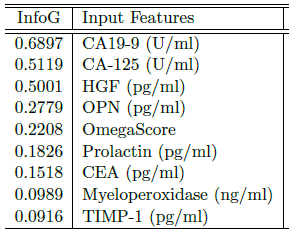

Verificación del "Information Gain" o peso de la variable frente a la variable objetivo a predecir.

#### 4.5.2.1 Método 1 Variables continuas, variable objetivo binaria --> Correlación de Pearson

In [18]:

print("[INFO] Teniendo variables predictivas numéricas continuas y una variable objetivo binaria, se hace uso del coeficiente de correlación de Pearson")
df_numericas = df.select_dtypes(include=['number'])
correlaciones = df_numericas.corrwith(df['Tumor type']).sort_values(ascending=False)

print("\tCorrelación de Pearson : ")
print(correlaciones)

[INFO] Teniendo variables predictivas numéricas continuas y una variable objetivo binaria, se hace uso del coeficiente de correlación de Pearson
	Correlación de Pearson : 
Tumor type                              1.000000
CancerSEEK Logistic Regression Score    0.732341
CancerSEEK Test Result                  0.640972
OPN (pg/ml)                             0.458352
Prolactin (pg/ml)                       0.324378
TIMP-1 (pg/ml)                          0.300539
GDF15 (ng/ml)                           0.247428
HGF (pg/ml)                             0.242512
Myeloperoxidase (ng/ml)                 0.221877
FGF2 (pg/ml)                            0.192212
IL-6 (pg/ml)                            0.186625
Galectin-3 (ng/ml)                      0.180836
Angiopoietin-2 (pg/ml)                  0.170233
OPG (ng/ml)                             0.147721
Omega score                             0.146759
HE4 (pg/ml)                             0.139689
Follistatin (pg/ml)                     0.13

#### 4.5.2.2 Método 2 - Variables discretas (KBinsDiscretizer()), variable objetivo binaria --> Correlación 

In [26]:
# Prueba discretización rápida + correlaciones 
from sklearn.preprocessing import KBinsDiscretizer

df_numericas = df.select_dtypes(include=['number'])
# Inicializar el discretizador basado en cuantiles
discretizer = KBinsDiscretizer(n_bins=12, encode='ordinal', strategy='quantile')

# Discretizar las variables numéricas continuas
df_numericas_discretas = pd.DataFrame(discretizer.fit_transform(df_numericas), columns=df_numericas.columns)

# Calcular el coeficiente de correlación entre las variables numéricas discretas y la variable objetivo binaria
correlaciones_discretas = df_numericas_discretas.corrwith(df['Tumor type'])

# Ordenar las correlaciones de mayor a menor
correlaciones_discretas_ordenadas = correlaciones_discretas.abs().sort_values(ascending=False)

# Obtener las top 10 variables numéricas discretas con las correlaciones más altas
top_15_correlaciones_discretas = correlaciones_discretas_ordenadas.nlargest(15)

# Imprimir las top 10 correlaciones
print(top_15_correlaciones_discretas)

CancerSEEK Logistic Regression Score    0.707618
IL-8 (pg/ml)                            0.577839
OPN (pg/ml)                             0.576522
IL-6 (pg/ml)                            0.475775
GDF15 (ng/ml)                           0.474454
Prolactin (pg/ml)                       0.447670
HGF (pg/ml)                             0.444292
Omega score                             0.379398
Myeloperoxidase (ng/ml)                 0.349025
TGFa (pg/ml)                            0.326160
sEGFR (pg/ml)                           0.320633
TIMP-1 (pg/ml)                          0.301831
CEA (pg/ml)                             0.301361
CA-125 (U/ml)                           0.288792
CA19-9 (U/ml)                           0.275198
dtype: float64


c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 42 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\danie\.virtualenvs\Repositorio_compartido-Xxik1eBC\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


#### 4.5.2.3 Método 3 - Variables discretizado (Arbol de decisión (max_depth = 15)), variable objetivo binaria --> Correlación 

In [48]:
def discretizar_df_arboles(df, max_depth=15, rango_discretizacion=(-np.inf, np.inf)):
    df_discretizado = pd.DataFrame()
    
    # Iterar sobre todas las columnas del dataframe original
    for columna in df.columns:
        if df[columna].dtype.kind in 'biufc': # (CHULO) Comprueba si el tipo de datos de la columna es numérico ('b' para booleano, 'i' para entero, 'u' para sin signo, 'f' para flotante o 'c' para complejo)
            # Si la columna es numérica, realizar la discretización
            dt = DecisionTreeRegressor(max_depth=max_depth)
            dt.fit(df[columna].values.reshape(-1, 1), df[columna])
            puntos_corte = dt.tree_.threshold[dt.tree_.threshold != -2] # Extrae los puntos de corte del árbol de decisión para la columna numérica específica, ignorando aquellos puntos de corte asociados con nodos hoja (-2)
            puntos_corte = np.sort(puntos_corte)
            puntos_corte = np.concatenate(([rango_discretizacion[0]], puntos_corte, [rango_discretizacion[1]]))
            # print(f"\t Columna : {columna} \n Puntos de Corte : \n {puntos_corte}")
            df_discretizado[f'{columna}'] = pd.cut(df[columna], bins=puntos_corte, labels=range(len(puntos_corte)-1))
        else:
            # Si la columna no es numérica, simplemente copiarla al dataframe resultante
            df_discretizado[columna] = df[columna]
            
    return df_discretizado

df_discret = discretizar_df_arboles(df.select_dtypes(include=['number']))

# Calcular el coeficiente de correlación entre las variables numéricas discretas y la variable objetivo binaria
correlaciones_discretas = df_discret.corrwith(df_discret['Tumor type'])

# Ordenar las correlaciones de mayor a menor
correlaciones_discretas_ordenadas = correlaciones_discretas.abs().sort_values(ascending=False)

# Obtener las top 20 variables numéricas discretas con las correlaciones más altas
top_20_correlaciones_discretas = correlaciones_discretas_ordenadas.nlargest(20)

# Imprimir las top 20 correlaciones
print(top_20_correlaciones_discretas)

Tumor type                              1.000000
CancerSEEK Logistic Regression Score    0.713090
CancerSEEK Test Result                  0.640972
OPN (pg/ml)                             0.575480
IL-6 (pg/ml)                            0.483620
IL-8 (pg/ml)                            0.464828
HGF (pg/ml)                             0.454991
Prolactin (pg/ml)                       0.453270
Omega score                             0.378112
GDF15 (ng/ml)                           0.365248
CYFRA 21-1 (pg/ml)                      0.356245
Myeloperoxidase (ng/ml)                 0.351481
sEGFR (pg/ml)                           0.319982
CA-125 (U/ml)                           0.312094
CEA (pg/ml)                             0.308045
TIMP-1 (pg/ml)                          0.301340
CA19-9 (U/ml)                           0.266444
Angiopoietin-2 (pg/ml)                  0.233881
HE4 (pg/ml)                             0.232766
Galectin-3 (ng/ml)                      0.232425
dtype: float64


#### 4.5.2.4 Método 4 [PAPER] - Variables discretizado (Random forest (n_estimators=250, criterion='gini') + cross validation), variable objetivo binaria --> Correlación 

In [149]:
# Mismo principio del papear : 5-fold cross-validations are run on the random forests of 250 Gini decision trees for 300 times to give the means and standard deviations as visualized on the error bars.
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

# Extract features (X) and target variable (y)
X = df.select_dtypes(include=['number']).drop(columns=['Tumor type']).values  # Features
y = df['Tumor type'].values  # Target variable
feature_names = df.select_dtypes(include=['number']).drop(columns=['Tumor type']).columns  # Feature names

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=250, criterion='gini')

# Train the Random Forest model on the entire dataset
rf_classifier.fit(X, y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Step 4: Perform Cross-Validation to get impurity decrease for each fold
cv_scores = []
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=42).split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train a model on the training data
    rf_classifier.fit(X_train, y_train)
    
    # Get impurity decrease for this fold
    fold_importances = rf_classifier.feature_importances_
    
    # Append impurity decrease to the list
    cv_scores.append(fold_importances)

# Convert list of arrays to a NumPy array
cv_scores = np.array(cv_scores)

# Calculate mean of feature importances for each feature
mean_feature_importances = np.mean(cv_scores, axis=0)

# Combine feature names and mean importances
feature_importance_pairs = list(zip(feature_names, mean_feature_importances))

# Sort features by mean importance (highest to lowest)
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Display feature names and their corresponding importances
for feature, importance in sorted_feature_importance_pairs:
    print(f"{feature}: {importance}")

CancerSEEK Logistic Regression Score: 0.16011521821126884
CancerSEEK Test Result: 0.10032455550714223
IL-8 (pg/ml): 0.0892343245533053
IL-6 (pg/ml): 0.06832820072008074
OPN (pg/ml): 0.059120792139012876
HGF (pg/ml): 0.04190430644931378
CYFRA 21-1 (pg/ml): 0.0389622350146014
GDF15 (ng/ml): 0.03771616270368018
Prolactin (pg/ml): 0.036723660119006796
TGFa (pg/ml): 0.03509116397981573
NSE (ng/ml): 0.02216511811777052
CA19-9 (U/ml): 0.022153042393356474
CA-125 (U/ml): 0.02127492298345869
HE4 (pg/ml): 0.019285642050482516
sFas (pg/ml): 0.016896473234596154
Thrombospondin-2 (pg/ml): 0.0157848630570856
Omega score: 0.01566884911588872
sEGFR (pg/ml): 0.014660936558307091
DKK1 (ng/ml): 0.01417835809212938
OPG (ng/ml): 0.010820906632388997
G-CSF (pg/ml): 0.010785879153216858
CD44 (ng/ml): 0.010611486937910457
Myeloperoxidase (ng/ml): 0.009729251590072008
sHER2/sEGFR2/sErbB2 (pg/ml): 0.009612473421891617
AFP (pg/ml): 0.008814860854754043
TIMP-1 (pg/ml): 0.008517105026723216
CEA (pg/ml): 0.00821237

#### 4.5.2.5 Métodos de prueba --> Discretizar uniformemente y por percentiles

In [66]:
def discretizar_frecuencia_uniforme(data, num_bins):
    bins = pd.cut(data, bins=num_bins, labels=False)
    return bins

def discretizar_percentiles(data, num_bins):
    bins = pd.qcut(data, q=num_bins, labels=False, duplicates='drop')
    return bins
def discretizar_uniforme_prueba_1(df):
    df_discretizado_prueba1 = pd.DataFrame()
    for columna in df.select_dtypes(include=['number']).columns:
            if df[columna].dtype.kind in 'biufc': # (CHULO) Comprueba si el tipo de datos de la columna es numérico ('b' para booleano, 'i' para entero, 'u' para sin signo, 'f' para flotante o 'c' para complejo)
                num_bins = int(1 + np.log2(len(df[columna])) + np.log2(np.std(df[columna])))
                print(f" Feature : {columna}, número de bins : {num_bins}")
                df_discretizado_prueba1[columna] = discretizar_frecuencia_uniforme(df[columna], num_bins)
            else:
                # Si la columna no es numérica, simplemente copiarla al dataframe resultante
                df_discretizado_prueba1[columna] = df[columna]

    # Calcular el coeficiente de correlación entre las variables numéricas discretas y la variable objetivo binaria
    correlaciones_discretas_p1 = df_discretizado_prueba1.corrwith(df_discretizado_prueba1['Tumor type'])

    # Ordenar las correlaciones de mayor a menor
    correlaciones_discretas_ordenadas_p1 = correlaciones_discretas_p1.abs().sort_values(ascending=False)

    # Obtener las top 20 variables numéricas discretas con las correlaciones más altas
    top_20_correlaciones_discretas_p1 = correlaciones_discretas_ordenadas_p1.nlargest(20)

    # Imprimir las top 20 correlaciones
    print(top_20_correlaciones_discretas_p1)

# ------------------------------------------------------------

def discretizar_percentiles_prueba_1(df):
    df_discretizado_prueba1 = pd.DataFrame()
    for columna in df.select_dtypes(include=['number']).columns:
        if df[columna].dtype.kind in 'biufc': # Comprueba si el tipo de datos de la columna es numérico
            num_bins = int(1 + np.log2(len(df[columna])) + np.log2(np.std(df[columna])))

            # Verificar si hay NaNs en los datos originales
            if df[columna].isnull().any():
                print(f"Advertencia: La columna '{columna}' contiene valores NaN.")

            # Discretizar solo si no hay NaNs en los datos originales
            if not df[columna].isnull().any():
                df_discretizado_prueba1[columna] = discretizar_percentiles(df[columna], num_bins)
                print(f"Feature : {columna}, número de bins : {num_bins}")

        else:
            # Si la columna no es numérica, simplemente copiarla al dataframe resultante
            df_discretizado_prueba1[columna] = df[columna]

    print(df_discretizado_prueba1.head(10))

    # Verificar si hay NaNs en los datos discretizados
    if df_discretizado_prueba1.isnull().any().any():
        print("Advertencia: Se han generado valores NaN durante la discretización.")

    # Calcular el coeficiente de correlación solo si no hay NaNs en los datos discretizados
    if not df_discretizado_prueba1.isnull().any().any():
        correlaciones_discretas_p1 = df_discretizado_prueba1.corrwith(df_discretizado_prueba1['Tumor type'])

        # Ordenar las correlaciones de mayor a menor
        correlaciones_discretas_ordenadas_p1 = correlaciones_discretas_p1.abs().sort_values(ascending=False)

        # Obtener las top 20 variables numéricas discretas con las correlaciones más altas
        top_20_correlaciones_discretas_p1 = correlaciones_discretas_ordenadas_p1.nlargest(20)

        # Imprimir las top 20 correlaciones
        print(top_20_correlaciones_discretas_p1)

In [ ]:
discretizar_uniforme_prueba_1(df)

In [ ]:
# No funciona, muestra todas las corelaciones como NaN
discretizar_percentiles_prueba_1(df)

### 4.5.3 Comparación de resultados de information gain

- Método 1 - Variables continuas, variable objetivo binaria --> Correlación de Pearson
- Método 2 - Variables discretas (KBinsDiscretizer()), variable objetivo binaria --> Correlación 
- Método 3 - Variables discretizado (Arbol de decisión (max_depth = 15)), variable objetivo binaria --> Correlación

 ------------- Método 1 ---------------------------------- Método 2 --------------------------- Método 3 -----------

|Variable|Valor|Variable|Valor|Variable|Valor|
|------------------------|--------------|-----------|-----------|--------------|------------|
| OPN (pg/ml)          |                 0.458352 | IL-8 (pg/ml)                 |           0.578037 |OPN (pg/ml)                  |         0.575480
Prolactin (pg/ml)       |                0.324378 | OPN (pg/ml)                   |          0.571791 |IL-6 (pg/ml)                  |           0.483620
TIMP-1 (pg/ml)          |                0.300539 | IL-6 (pg/ml)                  |          0.480112 |IL-8 (pg/ml)                  |          0.464828
GDF15 (ng/ml)           |                0.247428 | GDF15 (ng/ml)                 |          0.474477 |HGF (pg/ml)                |          0.454991
HGF (pg/ml)              |               0.242512 | Prolactin (pg/ml)              |         0.452567 |Prolactin (pg/ml)              |         0.453270
Myeloperoxidase (ng/ml)  |               0.221877 | HGF (pg/ml)                   |          0.447965 |Omega score                    |        0.378112
FGF2 (pg/ml)              |              0.192212 | Omega score                   |          0.363410 |GDF15 (ng/ml)                   |         0.365248
IL-6 (pg/ml)              |              0.186625 | Myeloperoxidase (ng/ml)       |          0.344990 |CYFRA 21-1 (pg/ml)         |         0.356245
Galectin-3 (ng/ml)        |              0.180836 | sEGFR (pg/ml)                 |          0.320824 |Myeloperoxidase (ng/ml)                 |          0.351481
Angiopoietin-2 (pg/ml)     |             0.170233 | CA19-9 (U/ml)                 |          0.311742 |sEGFR (pg/ml)                   |        0.319982
OPG (ng/ml)                |             0.147721 | TGFa (pg/ml)                   |         0.302511 |CA-125 (U/ml)                  |          0.312094
Omega score                |             0.146759 | TIMP-1 (pg/ml)                |          0.302504 |CEA (pg/ml)                |            0.308045
HE4 (pg/ml)                 |            0.139689 | CEA (pg/ml)                    |         0.300193 |TIMP-1 (pg/ml)                  |          0.301340
Follistatin (pg/ml)         |            0.137546 | CA-125 (U/ml)                 |         0.295434  |CA19-9 (U/ml)               |          0.266444
CEA (pg/ml)                 |            0.126718 | | | Angiopoietin-2 (pg/ml) |0.233881

PAPER : "Contrary to the information gain ranking on Table S1, the cancer
antigen markers are no longer the top predictive features. Instead, we observe the opposite trend for the
purity and accuracy measurements; such a phenomenon exemplifies the underlying complex behavior for
cancer detection"

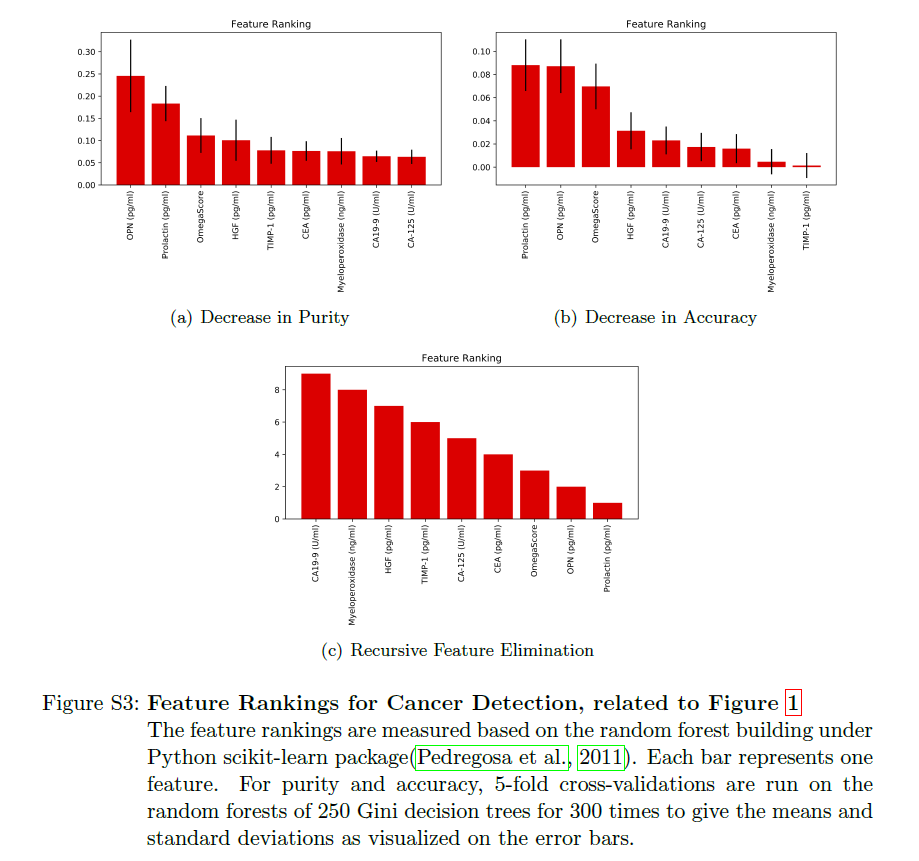

## 4.6 Discretizar variables numéricas

La discretización de variables numéricas puede tener un impacto significativo en el cálculo del Information Gain y en el rendimiento general del modelo, afectando aspectos como la discriminación de características, la capacidad de generalización, la interpretación del modelo y la complejidad del mismo

Los dataFrames disponibles para hacer las pruebas hasta el momento (dependiendo del proceso de relleno de datos nulos) :
- df6_prep_null_media
- df_imputed_linear
- df6_prep_null_KNN
- df_imputed_tree

(I) Se debe escoger entre uno ellos para continuar el proceso

### 4.5.1 Pruebas de discretización usando bins y la regla de Scott para asignación de bins

In [15]:
df6_prep_null_media.dtypes

Patient ID #                             object
Sample ID #                              object
Tumor type                               object
AJCC Stage                               object
AFP (pg/ml)                             float64
Angiopoietin-2 (pg/ml)                  float64
AXL (pg/ml)                             float64
CA-125 (U/ml)                           float64
CA 15-3 (U/ml)                          float64
CA19-9 (U/ml)                           float64
CD44 (ng/ml)                            float64
CEA (pg/ml)                             float64
CYFRA 21-1 (pg/ml)                      float64
DKK1 (ng/ml)                            float64
Endoglin (pg/ml)                        float64
FGF2 (pg/ml)                            float64
Follistatin (pg/ml)                     float64
Galectin-3 (ng/ml)                      float64
G-CSF (pg/ml)                           float64
GDF15 (ng/ml)                           float64
HE4 (pg/ml)                             

In [54]:
# P
# Función para calcular el número óptimo de bins basado en la regla de Scott
def calcular_bins(data):
    n = len(data)
    if n == 0:
        return 0
    else:
        iqr = np.percentile(data, 75) - np.percentile(data, 25)
        h = 3.5 * np.std(data) / np.power(n, 1/3)
        return int(np.ceil((np.max(data) - np.min(data)) / min(2 * h, iqr / 1.34)))

def discretizar_df(df):
    df_discretizado = pd.DataFrame()
    for columna in df.select_dtypes(include=['number']).columns:
        num_bins = calcular_bins(df[columna])
        # Discretizar y asignar valores numéricos a los intervalos
        discretized_column = pd.cut(df[columna], bins=num_bins, labels=False)
        df_discretizado[f'{columna}'] = discretized_column
    return df_discretizado

# Discretizar el DataFrame
df_discretizado = discretizar_df(df)

# Calcular el coeficiente de correlación entre las variables numéricas discretas y la variable objetivo binaria
correlaciones_discretas_1 = df_discretizado.corrwith(df['Tumor type'])

# Ordenar las correlaciones de mayor a menor
correlaciones_discretas_ordenadas_1 = correlaciones_discretas_1.abs().sort_values(ascending=False)

# Obtener las top 20 variables numéricas discretas con las correlaciones más altas
top_20_correlaciones_discretas_1 = correlaciones_discretas_ordenadas_1.nlargest(20)

# Imprimir las top 20 correlaciones
print(top_20_correlaciones_discretas_1)



Tumor type                              1.000000
CancerSEEK Logistic Regression Score    0.727572
CancerSEEK Test Result                  0.640972
OPN (pg/ml)                             0.445743
Prolactin (pg/ml)                       0.323272
TIMP-1 (pg/ml)                          0.293960
sEGFR (pg/ml)                           0.277766
HGF (pg/ml)                             0.228759
GDF15 (ng/ml)                           0.226116
Myeloperoxidase (ng/ml)                 0.220389
FGF2 (pg/ml)                            0.187579
Galectin-3 (ng/ml)                      0.183529
IL-6 (pg/ml)                            0.172968
Angiopoietin-2 (pg/ml)                  0.169863
OPG (ng/ml)                             0.159473
Omega score                             0.146611
Follistatin (pg/ml)                     0.142548
HE4 (pg/ml)                             0.139336
CEA (pg/ml)                             0.125353
G-CSF (pg/ml)                           0.120419
dtype: float64


### 4.5.2 Prueba de discretización usando el principio de MDL

[DUDA - Cambiar a numérico y luego aplicar MDL?]

En el estudio CancerA1DE, se aplica el principio MDL (Minimum Description Length), basado en la idea de que el mejor modelo es aquel que minimiza la longitud de la descripción del conjunto de datos, teniendo en cuenta tanto la capacidad de ajuste del modelo como la simplicidad del mismo. 
Por tanto, trata de encontrar la mejor manera de dividir los valores de una característica continua en intervalos discretos o categorías.

Ejecutar el principio de MDL para discretizar las muestras de las variables

- Se inicializa la JVM de Weka.
- Se carga el conjunto de datos ARFF.
- Se configura el filtro de selección de características utilizando ASSearch para buscar las mejores características utilizando el algoritmo BestFirst y ASEvaluation para evaluar la ganancia de información.
- Se aplica el filtro de selección de características al conjunto de datos.
- Se entrena un clasificador J48 utilizando las características seleccionadas.
- Se evalúa el modelo utilizando validación cruzada de 10 pliegues.
- Finalmente, se imprime un resumen de la evaluación.

In [ ]:
## TO DO - NO FUNCIONA
# pip install weka

import weka.core.jvm as jvm
from weka.core.converters import Loader
from weka.attribute_selection import ASSearch, ASEvaluation, AttributeSelection
from weka.classifiers import Classifier, Evaluation
from weka.classifiers import FilteredClassifier
from weka.filters import Filter

# Inicializar JVM de Weka
jvm.start()

# Cargar el conjunto de datos
data = df6_prep
data.class_is_last()

# Crear el filtro de selección de características
search = ASSearch(classname="weka.attributeSelection.BestFirst", options=["-D", "1", "-N", "5"])
evaluation = ASEvaluation(classname="weka.attributeSelection.InfoGainAttributeEval")
selector = AttributeSelection()
selector.search(search)
selector.evaluator(evaluation)
selector.select_attributes(data)

# Obtener el índice de las características seleccionadas
selected_attributes = selector.selected_attributes()

# Crear el clasificador
classifier = Classifier(classname="weka.classifiers.trees.J48")

# Combinar el clasificador con el filtro de selección de características
filtered_classifier = FilteredClassifier()
filtered_classifier.filter(selector)
filtered_classifier.classifier(classifier)

# Evaluar el modelo
evaluation = Evaluation(data)
evaluation.crossvalidate_model(filtered_classifier, data, 10, Random(1))
print(evaluation.summary())


### 4.5.3  Discretización basada en árboles de decisión

Discretización mediante arboles de decisión. Se aumenta el max_depth (profundidad máxima) para capturar mejor la variabilidad de los datos (discretizar_df_arboles_2)

Una vez discretizado, el tipo de las variables pasa a ser categórico

In [16]:
df6_prep_null_media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1817 entries, 0 to 1816
Data columns (total 46 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Patient ID #                          1817 non-null   object 
 1   Sample ID #                           1817 non-null   object 
 2   Tumor type                            1817 non-null   object 
 3   AJCC Stage                            1005 non-null   object 
 4   AFP (pg/ml)                           1817 non-null   float64
 5   Angiopoietin-2 (pg/ml)                1817 non-null   float64
 6   AXL (pg/ml)                           1817 non-null   float64
 7   CA-125 (U/ml)                         1817 non-null   float64
 8   CA 15-3 (U/ml)                        1817 non-null   float64
 9   CA19-9 (U/ml)                         1817 non-null   float64
 10  CD44 (ng/ml)                          1817 non-null   float64
 11  CEA (pg/ml)      

- **max_depth**: Este parámetro controla la profundidad máxima del árbol de decisión. Una profundidad mayor permite que el árbol sea más complejo y se ajuste mejor a los datos de entrenamiento, pero también aumenta el riesgo de sobreajuste. Un valor más alto de 'max_depth' permite capturar relaciones más complejas en los datos, pero también aumenta la complejidad computacional y el riesgo de sobreajuste. Un valor típico puede estar en el rango de 5 a 20, pero esto puede variar según el conjunto de datos y el problema específico.

- **n_bins**: Este parámetro especifica el número de bins en los que se dividirá el rango de valores de la variable numérica después de la discretización. Un valor más alto de 'n_bins' dará como resultado una discretización más fina, mientras que un valor más bajo dará como resultado una discretización más gruesa. Al igual que con 'max_depth', no hay un valor único óptimo para 'n_bins'; depende de la distribución de los datos y la sensibilidad del problema. Un valor típico puede estar en el rango de 5 a 20 o más, dependiendo de la cantidad de datos y la naturaleza del problema.

In [41]:
# P

def discretizar_df_arboles_2(df, max_depth=15, n_bins=10, rango_discretizacion=(-np.inf, np.inf)):
    df_discretizado = pd.DataFrame()
    
    # Iterar sobre todas las columnas del dataframe original
    for columna in df.columns:
        if df[columna].dtype.kind in 'biufc':
            # Si la columna es numérica, realizar la discretización
            dt = DecisionTreeRegressor(max_depth=max_depth)
            dt.fit(df[columna].values.reshape(-1, 1), df[columna])
            puntos_corte = dt.tree_.threshold[dt.tree_.threshold != -2]
            puntos_corte = np.sort(puntos_corte)
            puntos_corte = np.concatenate(([rango_discretizacion[0]], puntos_corte, [rango_discretizacion[1]]))
            df_discretizado[f'{columna}'] = pd.cut(df[columna], bins=puntos_corte, labels=range(len(puntos_corte)-1))
        else:
            # Si la columna no es numérica, simplemente copiarla al dataframe resultante
            df_discretizado[columna] = df[columna]
            
    return df_discretizado

def discretizar_df_arboles_3(df, max_depth=20, n_bins=15, rango_discretizacion=(-np.inf, np.inf)):
    df_discretizado = pd.DataFrame()
    
    # Iterar sobre todas las columnas del dataframe original
    for columna in df.columns:
        if df[columna].dtype.kind in 'biufc': # (CHULO) Comprueba si el tipo de datos de la columna es numérico ('b' para booleano, 'i' para entero, 'u' para sin signo, 'f' para flotante o 'c' para complejo)
            # Si la columna es numérica, realizar la discretización
            dt = DecisionTreeRegressor(max_depth=max_depth)
            dt.fit(df[columna].values.reshape(-1, 1), df[columna])
            puntos_corte = dt.tree_.threshold[dt.tree_.threshold != -2] # Extrae los puntos de corte del árbol de decisión para la columna numérica específica, ignorando aquellos puntos de corte asociados con nodos hoja (-2)
            puntos_corte = np.sort(puntos_corte)
            puntos_corte = np.concatenate(([rango_discretizacion[0]], puntos_corte, [rango_discretizacion[1]]))
            df_discretizado[f'{columna}'] = pd.cut(df[columna], bins=puntos_corte, labels=range(len(puntos_corte)-1))
        else:
            # Si la columna no es numérica, simplemente copiarla al dataframe resultante
            df_discretizado[columna] = df[columna]
            
    return df_discretizado


df_discretizado_arboles_v2 = discretizar_df_arboles_2(df6_prep_null_media)
df_discretizado_arboles_v3 = discretizar_df_arboles_3(df6_prep_null_media)


print(df_discretizado_arboles_v2.head(10))
print(df_discretizado_arboles_v3.head(10))

  Patient ID #    Sample ID #  Tumor type AJCC Stage AFP (pg/ml)  \
0      CRC 455  CRC 455 PLS 1  Colorectum          I         280   
1      CRC 456  CRC 456 PLS 1  Colorectum          I           1   
2      CRC 457  CRC 457 PLS 1  Colorectum         II         623   
3      CRC 458  CRC 458 PLS 1  Colorectum         II           1   
4      CRC 459  CRC 459 PLS 1  Colorectum         II          17   
5      CRC 460  CRC 460 PLS 1  Colorectum         II           1   
6      CRC 461  CRC 461 PLS 1  Colorectum          I         373   
7      CRC 462  CRC 462 PLS 1  Colorectum          I         106   
8      CRC 463  CRC 463 PLS 1  Colorectum          I         123   
9      CRC 464  CRC 464 PLS 1  Colorectum        III         694   

  Angiopoietin-2 (pg/ml) AXL (pg/ml) CA-125 (U/ml) CA 15-3 (U/ml)  \
0                   1679        1510            31            916   
1                   1727        1235           148            477   
2                   1309        1598        

In [42]:
df_discretizado_arboles_v3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1817 entries, 0 to 1816
Data columns (total 46 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   Patient ID #                          1817 non-null   object  
 1   Sample ID #                           1817 non-null   object  
 2   Tumor type                            1817 non-null   object  
 3   AJCC Stage                            1005 non-null   object  
 4   AFP (pg/ml)                           1817 non-null   category
 5   Angiopoietin-2 (pg/ml)                1817 non-null   category
 6   AXL (pg/ml)                           1817 non-null   category
 7   CA-125 (U/ml)                         1817 non-null   category
 8   CA 15-3 (U/ml)                        1817 non-null   category
 9   CA19-9 (U/ml)                         1817 non-null   category
 10  CD44 (ng/ml)                          1817 non-null   category
 11  CEA 

### 4.5.4 Observar las variables discretizadas

Una vez aplicado el principio de MDL se muestran en histogramas las variables discretizadas

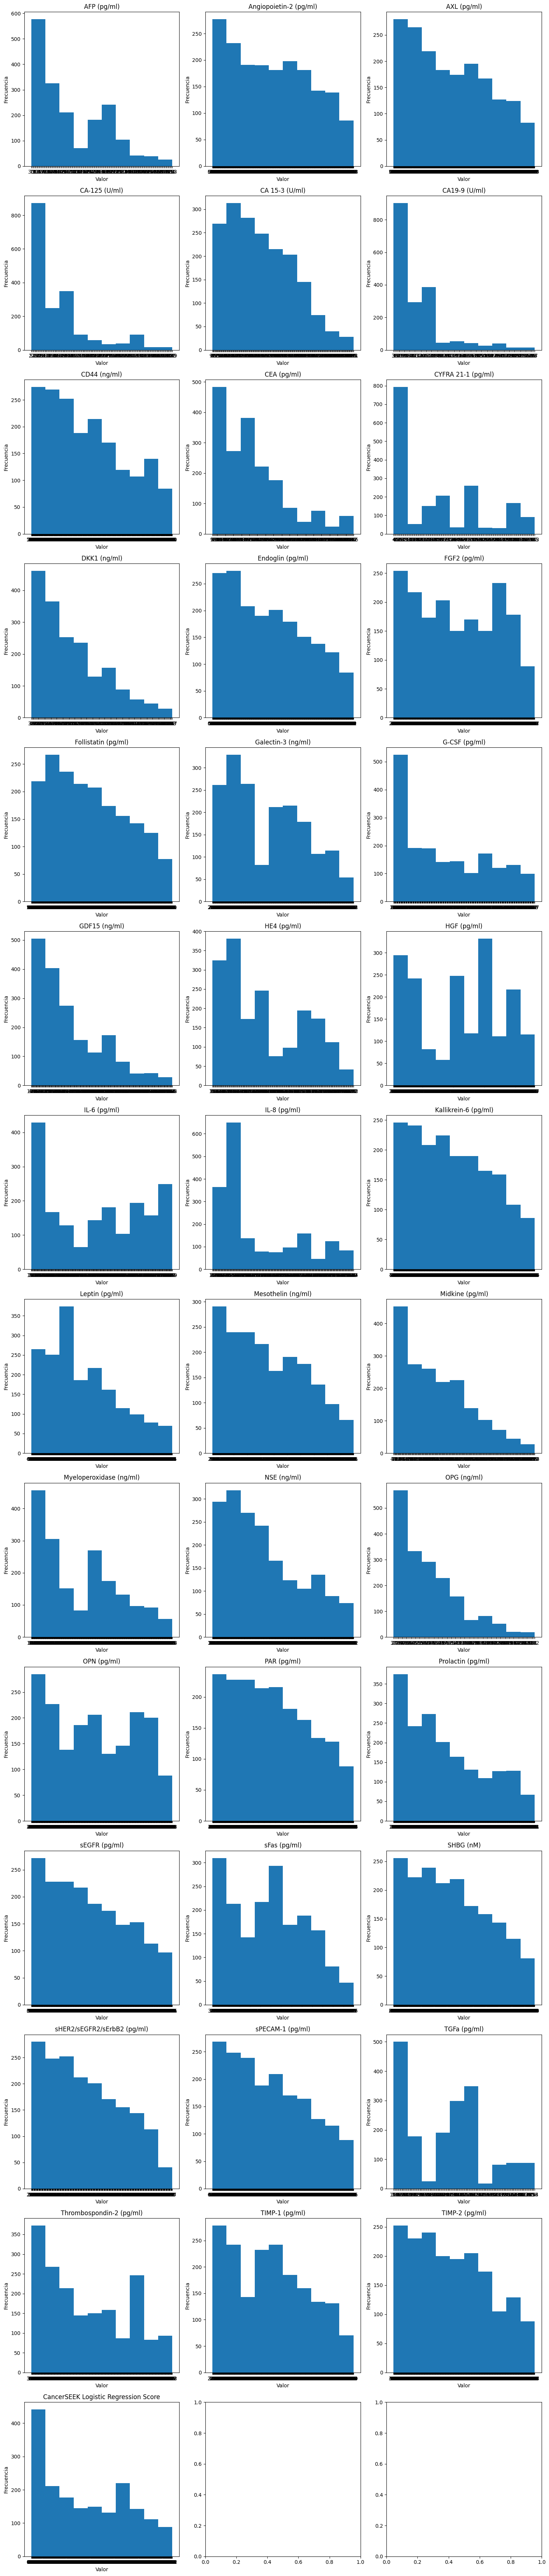

In [25]:
# (I) Definir que dataFrame discretizado se quiere mostrar :
df_discretizado = df_discretizado_arboles_v2
# Definir el número de histogramas por fila
histogramas_por_fila = 3

# Obtener el número total de variables y calcular el número total de filas necesarias
num_variables = len(df_discretizado.columns)
num_filas = (num_variables + histogramas_por_fila - 1) // histogramas_por_fila

# Crear una figura y ejes para subplots
fig, axs = plt.subplots(num_filas, histogramas_por_fila, figsize=(15, 5*num_filas))

# Iterar sobre cada variable y dibujar su histograma en un subplot
for i, columna in enumerate(df_discretizado.columns):
    fila = i // histogramas_por_fila
    columna_subplot = i % histogramas_por_fila
    
    # Convertir los valores flotantes en cadenas
    datos_columna = df_discretizado[columna].astype(str)
    
    axs[fila, columna_subplot].hist(datos_columna, bins=10)  # Puedes ajustar el número de bins si lo deseas
    axs[fila, columna_subplot].set_title(columna)
    axs[fila, columna_subplot].set_xlabel('Valor')
    axs[fila, columna_subplot].set_ylabel('Frecuencia')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar los subplots
plt.show()

## 4.7 Reducir número de variables

[DUDA] Al hacer un df_discretizado.head(), el resultado obtenido no se si es el esperado (habiendo ejecutado el apartado 4.5.1 discretizacion con bis y regla de Scott)

In [ ]:
#Valores no discretizados 
df6_prep_null_media.dtypes

#Valores discretizados
df_discretizado_arboles_v2.dtypes



In [63]:
df_discretizado_arboles_v2.describe

# Conservar solo las columnas 'CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)'
columnas_a_conservar = ['CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)']
df_discretizado_reducido = df_discretizado_arboles_v2[columnas_a_conservar]


df6_prep_null_media.describe
# Conservar solo las columnas 'CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)'
columnas_a_conservar = ['CA19-9 (U/ml)', 'CA-125 (U/ml)','HGF (pg/ml)','OPN (pg/ml)', 'Omega score', 'Prolactin (pg/ml)', 'CEA (pg/ml)', 'Myeloperoxidase (ng/ml)', 'TIMP-1 (pg/ml)']
df_No_discretizado_reducido = df6_prep_null_media[columnas_a_conservar]

df_No_discretizado_reducido.head()
df_discretizado_reducido.head()

,CA19-9 (U/ml),CA-125 (U/ml),HGF (pg/ml),OPN (pg/ml),Omega score,Prolactin (pg/ml),CEA (pg/ml),Myeloperoxidase (ng/ml),TIMP-1 (pg/ml)
0,3,5,171,319,62,79,5,88,208
1,36,21,261,342,52,106,99,143,319
2,3,2,148,468,24,250,21,72,29
3,3,7,109,228,35,84,48,31,20
4,3,2,168,106,27,171,9,82,208


#  FUNCIONES

In [ ]:
# FUNCIONES
# Función de limpieza de datos total del dataFrame
def limpiar_datos(df):
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.impute import SimpleImputer
    """
    Realiza la limpieza de datos en un DataFrame, incluyendo imputación de valores faltantes, 
    escalado y codificación one-hot para variables categóricas.

    Args:
        df (pandas.DataFrame): El DataFrame que contiene los datos.

    Returns:
        pandas.DataFrame: El DataFrame con los datos limpios, escalados y codificados.
    """
    # Separar variables numéricas y categóricas
    df_numeric = df.select_dtypes(include=np.number)
    df_categorical = df.select_dtypes(exclude=np.number)
    
    # Imputación de valores faltantes para variables numéricas
    imputer = SimpleImputer(strategy='mean')
    df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)
    
    # Escalado de variables numéricas
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df_imputed.columns)
    
    # Codificación one-hot para variables categóricas
    encoder = OneHotEncoder(drop='first', sparse=False)
    df_encoded = pd.DataFrame(encoder.fit_transform(df_categorical), columns=encoder.get_feature_names_out(df_categorical.columns))
    
    # Unir los DataFrames de variables numéricas escaladas y categóricas codificadas
    df_cleaned = pd.concat([df_scaled, df_encoded], axis=1)
    
    return df_cleaned

# Función para limpiar una columna particular pasada como parámetro a la función
def limpiar_columna(columna):
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.impute import SimpleImputer
    """
    Realiza la limpieza de datos para una columna específica del DataFrame, incluyendo imputación de valores faltantes 
    y escalado para variables numéricas, y codificación one-hot para variables categóricas.

    Args:
        df (pandas.DataFrame): El DataFrame que contiene los datos.
        columna (str): El nombre de la columna a limpiar.

    Returns:
        pandas.Series: La columna ya limpia.
    """
    # Verificar si la columna es numérica o categórica
    if pd.api.types.is_numeric_dtype(df[columna]):
        # Imputación de valores faltantes con la media
        imputer = SimpleImputer(strategy='mean')
        df[columna] = imputer.fit_transform(df[[columna]])
        
        # Escalado de datos
        scaler = StandardScaler()
        df[columna] = scaler.fit_transform(df[[columna]])
    else:
        # Imputación de valores faltantes con la moda
        imputer = SimpleImputer(strategy='most_frequent')
        df[columna] = imputer.fit_transform(df[[columna]])
        
        # Codificación one-hot para variables categóricas
        encoder = OneHotEncoder(drop='first', sparse=False)
        encoded_data = encoder.fit_transform(df[[columna]])
        column_names = encoder.get_feature_names_out([columna])
        df_encoded = pd.DataFrame(encoded_data, columns=column_names)
        
        # Eliminar la columna original y agregar las columnas codificadas
        df = pd.concat([df.drop(columns=[columna]), df_encoded], axis=1)
    
    return df[columna]

# ---------------------------------------------------------------------------------------------

# Función para eliminar filas y columnas (normalmente por carecer de datos suficientes)
# Eliminar filas con valores faltantes
def eliminar_filas_con_nulos(df, columna):
    return df.dropna(subset=[columna], inplace=True)

# Elimina la columna pasada como parámetro
def eliminar_col(columnName):
    df.drop(columns = columnName, inplace=True)
# --------------------------------------------------------------------

# Funciones para rellenar valores faltantes
# Rellenar con la media o la mediana (variables numéricas)
def fill_mean_or_median(columnName,value):
    if value == 'mean':
        df[columnName].fillna(df[columnName].mean(), inplace=True)
    elif value == 'median':
        df[columnName].fillna(df[columnName].median(), inplace=True)

# Rellenar con la moda (variables categóricas)
def fill_mode(columnName):
    df[columnName].fillna(df[columnName].mode().iloc[0], inplace=True)

# Rellenar valores faltantes con un valor específico (variables numéricas o categóricas)
def fill_with_value(columnName,value) :
    df[columnName].fillna(value=value, inplace=True)

# Rellenar valores faltantes con el valor siguiente (variables ordenadas en el tiempo)
def fill_with_forward(columnName):
    df[columnName].fillna(method='ffill', inplace=True)

# Rellenar valores faltantes con el valor anterior (variables ordenadas en el tiempo)
def fill_with_back(columnName):
    df[columnName].fillna(method='bfill', inplace=True)

# Interpolación lineal para rellenar valores faltantes (variables numéricas ordenadas)
def fill_with_interpolation(columnName) :
    df[columnName].interpolate(method='linear', inplace=True)

# 5. OBTENCION DEL TRAIN SET

In [45]:
# (I) Introducir valor de dataFrame [df1, df2, df3, ... , df9]
dataFrame = df4
print(dataFrame.info())
df4_processed = limpiar_datos(dataFrame)
print(df4_processed.info())
# df4_processed.drop(columns=[''])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1817 entries, 0 to 1816
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Patient ID #                          1817 non-null   object 
 1   Plasma sample ID #                    1817 non-null   object 
 2   Primary tumor sample ID #             1817 non-null   object 
 3   Age                                   1817 non-null   float64
 4   Sex                                   1817 non-null   object 
 5   Race                                  1817 non-null   object 
 6   Tumor type                            1817 non-null   object 
 7   AJCC Stage                            1005 non-null   object 
 8   Histopathology                        1005 non-null   object 
 9   Plasma volume (mL)                    1817 non-null   float64
 10  Plasma DNA concentration (ng/mL)      1817 non-null   float64
 11  CancerSEEK Logist

c:\Users\danie\.virtualenvs\Plantillas-rmuV9HM5\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1817 entries, 0 to 1816
Columns: 4473 entries, Age to CancerSEEK Test Result_Positive
dtypes: float64(4473)
memory usage: 62.0 MB
None


In [41]:
# (I) Introducir valor de dataFrame [df1, df2, df3, ... , df9]
dataFrame = df4
print(df4.head())
df4_tmp = df.drop()
# (I) Introducir valor de variableAPredecir
'''variableAPredecir = 'variableAPredecir'
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(variableAPredecir, axis = 'columns'),
                                        df[variableAPredecir],
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle      = True
                                    )
                                    '''

  Patient ID # Plasma sample ID # Primary tumor sample ID #        Age  \
0      CRC 455      CRC 455 PLS 1             Not available  59.811088   
1      CRC 456      CRC 456 PLS 1               CRC 456 PT1  59.091034   
2      CRC 457      CRC 457 PLS 1               CRC 457 PT1  68.618754   
3      CRC 458      CRC 458 PLS 1               CRC 458 PT1  69.563313   
4      CRC 459      CRC 459 PLS 1               CRC 459 PT1  43.359343   

      Sex       Race  Tumor type AJCC Stage  Histopathology  \
0    Male  Caucasian  Colorectum          I  Adenocarcinoma   
1  Female  Caucasian  Colorectum          I  Adenocarcinoma   
2  Female  Caucasian  Colorectum         II  Adenocarcinoma   
3  Female  Caucasian  Colorectum         II  Adenocarcinoma   
4  Female  Caucasian  Colorectum         II  Adenocarcinoma   

   Plasma volume (mL)  Plasma DNA concentration (ng/mL)  \
0                 5.0                          6.079696   
1                 4.0                         46.005220   

"variableAPredecir = 'variableAPredecir'\nX_train, X_test, y_train, y_test = train_test_split(\n                                        df.drop(variableAPredecir, axis = 'columns'),\n                                        df[variableAPredecir],\n                                        train_size   = 0.8,\n                                        random_state = 42,\n                                        shuffle      = True\n                                    )\n                                    "

# 6. ESTANDARIZACIÓN/NORMALIZACIÓN DE LAS COLUMNAS NUMÉRICAS Y BINARIZACION DE LAS VARIABLES CATEGÓRICAS

Cuando los predictores son numéricos, la escala en la que se miden, así como la magnitud de su **varianza** pueden influir en gran medida en el modelo. Muchos algoritmos de machine learning (SVM, redes neuronales, lasso...) son sensibles a esto, de forma que, si no se igualan de alguna forma los predictores, aquellos que se midan en una escala mayor o que tengan más varianza dominarán el modelo aunque no sean los que más relación tienen con la variable respuesta.

**Normalización** (estandarización): consiste en transformar los datos de forma que todos los predictores estén aproximadamente en la misma escala. 

    Hay dos formas de lograrlo:
    - Normalización Z-score (`StandardScaler`): dividir cada predictor entre su desviación típica después de haber sido centrado, de esta forma, los datos pasan a tener una distribución normal.
    - Estandarización max-min (`MinMaxScaler`): transformar los datos de forma que estén dentro del rango `[0, 1]`.

**Binarización de las variables cualitativas :**

    La binarización (*one-hot-encoding*) consiste en crear nuevas variables *dummy* con cada uno de los niveles de las variables cualitativas.

In [ ]:
# Selección de las variables por tipo
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

# Se estandarizan las columnas numéricas y se hace one-hot-encoding de las 
# columnas cualitativas. Para mantener las columnas a las que no se les aplica 
# ninguna transformación se tiene que indicar remainder='passthrough'.
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)],
                remainder = 'passthrough',
                verbose_feature_names_out = False
               ).set_output(transform="pandas")

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

X_train_prep.head(3)

# 7. CREACIÓN DEL MODELO

El siguiente paso tras definir los datos de entrenamiento, es seleccionar el algoritmo que se va a emplear. En **scikit-learn**, esto se hace mediante la creación de un objeto `estimator`. En concreto, este objeto almacena el nombre del algoritmo, sus parámetros e hiperparámetros y contiene los métodos `fit(X, y)` y `predict(y_)` que le permiten aprender de los datos y predecir nuevas observaciones.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train_prep, y_train)

# 8. VALIDACIÓN

La finalidad última de un modelo es predecir la variable respuesta en observaciones futuras o en observaciones que el modelo no ha "visto" antes. El error mostrado por defecto tras entrenar un modelo suele ser el error de entrenamiento, el error que comete el modelo al predecir las observaciones que ya ha "visto". Si bien estos errores son útiles para entender cómo está aprendiendo el modelo (estudio de residuos), no es una estimación realista de cómo se comporta el modelo ante nuevas observaciones (el error de entrenamiento suele ser demasiado optimista). Para conseguir una estimación más certera, y antes de recurrir al conjunto de **test**, se pueden emplear estrategias de validación basadas en resampling. **Scikit-learn** incorpora en el módulo `sklearn.model_selection` varias estrategias de validación.

Todas ellas reciben como primer argumento un estimator que puede ser directamente un *modelo* o un *pipeline*.

Las métricas de error de regresión se devuelven siempre en negativo de forma que, cuanto más próximo a 0 sea el valor, mejor el ajuste. Esto es así para que, los procesos de optimización siempre sean de maximización.

La forma más sencilla es emplear la función `cross_val_score()`, que utiliza por defecto `KFold`.

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
                estimator = model,
                X         = X_train_prep,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
            )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

# 9. Predicción

Una vez que el modelo ha sido entrenado, bien empleando directamente un *estimator* o un *pipeline*, con el método `.predict()` se pueden predecir nuevas observaciones. Si se emplea un pipeline, se aplican automáticamente las transformaciones aprendidas durante el entrenamiento.

In [ ]:
predicciones = model.predict(X_test_prep)

# Se crea un dataframe con las predicciones y el valor real
df_predicciones = pd.DataFrame({'precio' : y_test, 'prediccion' : predicciones})
df_predicciones.head()

# 10. Error del test
El módulo `sklearn.metrics` incorpora una variedad considerable de métricas para evaluar la calidad de las predicciones.

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones,
        squared = False
       )
rmse

# 11. INTERPRETACIÓN

# EXTRAS

---


**Texto en negrita**

*Texto en cursiva*

~~Texto tachado~~, pero este no está tachado

---
<font color="#004D7F" size=6 style="font-family:Verdana;">Enlaces</font>

[Texto del enlace](https://www.example.com)

[Ancla a parte del código (título Markdown)](#bloque2)

![Imagen de Kschool](https://nachocarnes.es/wp-content/uploads/2018/04/ejWGXui6_400x400.png)

Opción 2

<center><img src="https://nachocarnes.es/wp-content/uploads/2018/04/ejWGXui6_400x400.png" alt="Drawing" style="align=left"/>

In [ ]:
!git clone https://github.com/emunozlorenzo/DataCopCrimePrediction.git

Cloning into 'DataCopCrimePrediction'...
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 367 (delta 55), reused 58 (delta 30), pack-reused 271
Receiving objects: 100% (367/367), 14.71 MiB | 21.93 MiB/s, done.
Resolving deltas: 100% (188/188), done.


#### **Aquí os añado la referencia a una pagina donde podéis encontrar muchos más ejemplos:**
1. https://daringfireball.net/projects/markdown/basics
2. https://programmerclick.com/article/9139292621/